In [12]:
pip install contractions

In [13]:
pip install vaderSentiment

In [14]:
import os
import pandas as pd
import re
import nltk
import contractions
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Load the CSV data into a DataFrame
csv_file = "/content/drive/MyDrive/Machine Learning 1/combined_data.csv"
df = pd.read_csv(csv_file)

In [15]:
df.dropna(subset=['body'], inplace=True)
df.drop_duplicates(subset='body', inplace=True)
df = df[df['body'].apply(len) > 5]
df.shape[0]

3096178

In [19]:

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [20]:
flagged_df = df.iloc[:len(df) // 2]
non_flagged_df = df.iloc[len(df) // 2:]

num_samples_per_class = 100000
# Randomly sample from each class to create a balanced dataset
flagged_sampled = flagged_df.sample(n=num_samples_per_class, random_state=50)
non_flagged_sampled = non_flagged_df.sample(n=num_samples_per_class, random_state=50)

# # Concatenate the sampled DataFrames to create the balanced dataset
df = pd.concat([flagged_sampled, non_flagged_sampled], ignore_index=True)

In [21]:
'''
Added 2 more pre processing steps.
'''

import pandas as pd
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet, stopwords
import contractions
def preprocess_text(text):
    if pd.isna(text) or not text.strip():
        return ''  # Replace empty strings or NaN with an empty string

    text = text.lower()
    text = re.sub(r'[^\w\s,]', '', text)
    text = re.sub(r'[0-9]', '', text)
    text = ''.join(char for char in text if ord(char) < 128)

    # Normalize contractions
    text = contractions.fix(text)

    # Tokenize the text using NLTK's word_tokenize
    words = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))  # Change 'english' to your language if needed
    words = [word for word in words if word not in stop_words]

    # Perform stemming and lemmatization
    '''
    Stemmer and lemmatizer are going to convert a word to it's root form.
    '''
    # stemmer = PorterStemmer()
    # lemmatizer = WordNetLemmatizer()
    # words = [stemmer.stem(lemmatizer.lemmatize(word)) for word in words]

    return ' '.join(words)

df['body'] = df['body'].apply(preprocess_text)
# Check the number of rows in the DataFrame after preprocessing
num_rows = df.shape[0]
print(f'Number of rows after preprocessing: {num_rows}')

Number of rows after preprocessing: 200000


In [22]:
'''
Added Word Cloud Visualization for the over all input.
'''
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color='white',stopwords=stopwords,max_words = 5000,max_font_size = 50, scale = 5).generate(str(df['body']))
plt.imshow(wordcloud)

NameError: ignored

In [23]:
'''
Added Word Cloud Visualization for each label.
'''
plt.figure(figsize=(40,20))
for index, sent in enumerate(df['label'].unique()):
    plt.subplot(2,2,index+1)
    data = df[df['label'] == sent]['body']
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(background_color='white',stopwords=stopwords,max_words = 5000,max_font_size = 50, scale = 5).generate(str(df['body']))
    plt.imshow(wordcloud)
    plt.xticks([])
    plt.yticks([])
    plt.title(sent,fontsize=40)

NameError: ignored

In [24]:
# Label Encoding
df['label'] = df['label'].map({'deleted': 1, 'hidden': 1, 'nonflagged': 0})

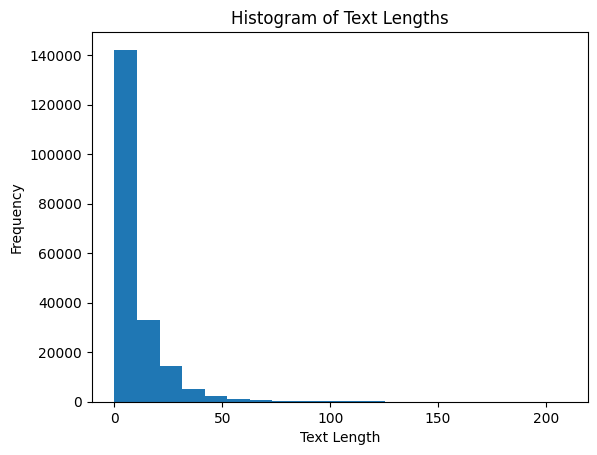

In [25]:
import matplotlib.pyplot as plt

# Calculate the length of each body and create a histogram
df['text_length'] = df['body'].apply(len)
plt.hist(df['text_length'], bins=20)  # Adjust the number of bins as needed
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Histogram of Text Lengths')
plt.show()

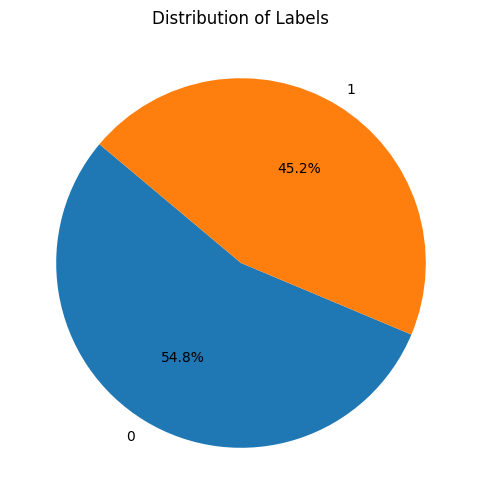

In [26]:
import seaborn as sns

label_counts = df['label'].value_counts()

# Create a pie chart
plt.figure(figsize=(6, 6))  # Set the figure size
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Labels')

plt.show()

In [27]:
# Feature Extraction using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
X = tfidf_vectorizer.fit_transform(df['body'])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, df['label'], test_size=0.2, random_state=42)

In [29]:
'''
Added Feature Extraction using Word2Vec

'''

# Feature Extraction using Word2Vec
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np


# Train Word2Vec model
word2vec_model = Word2Vec(sentences=df['body'], vector_size=100, window=10, min_count=5, workers=5)

# Function to calculate the average word vector for a document
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.

    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector

# Create word vectors for each document
X_word2vec = [average_word_vectors(words, word2vec_model, word2vec_model.wv.index_to_key, 100) for words in df['body']]

# Convert to numpy array
X_word2vec = np.array(X_word2vec)

# Label Encoding for the target variable
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_word2vec, df['label'], test_size=0.2, random_state=42)

In [30]:
'''
Added Feature Extraction using Sentiment Lexicon
'''

from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=df['body'], vector_size=100, window=10, min_count=5, workers=5)

# Function to calculate the average word vector for a document
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.

    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector

# Create word vectors for each document
X_word2vec = [average_word_vectors(words, word2vec_model, word2vec_model.wv.index_to_key, 100) for words in df['body']]

# Convert to numpy array
X_word2vec = np.array(X_word2vec)

# Add sentiment lexicon features using vaderSentiment
analyzer = SentimentIntensityAnalyzer()

# Calculate sentiment scores for each document
sentiment_scores = df['body'].apply(lambda x: analyzer.polarity_scores(x))

# Extract compound sentiment scores
compound_scores = sentiment_scores.apply(lambda x: x['compound']).values.reshape(-1, 1)

# Concatenate sentiment lexicon features with Word2Vec features
X_combined = np.concatenate((X_word2vec, compound_scores), axis=1)

# Label Encoding for the target variable
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_combined, df['label'], test_size=0.2, random_state=42)

In [31]:
'''
Added Feature Extraction using fastText
'''
from gensim.models import FastText
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Train fastText model
fasttext_model = FastText(sentences=df['body'], vector_size=200, window=10, min_count=5, workers=5)

# Function to calculate the average word vector for a document using fastText
def average_word_vectors_fasttext(words, model, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.

    for word in words:
        nwords = nwords + 1.
        feature_vector = np.add(feature_vector, model.wv[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector

# Create word vectors for each document using fastText
X_fasttext = [average_word_vectors_fasttext(words, fasttext_model, 200) for words in df['body']]

# Convert to numpy array
X_fasttext = np.array(X_fasttext)

# Label Encoding for the target variable
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_fasttext, df['label'], test_size=0.2, random_state=42)

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [33]:
'''
Model Training using Logistic Regression
'''

model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

# Model Evaluation
y_pred = model.predict(X_test)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Calculate classification report (includes precision, recall, and F1-score)
class_report = classification_report(y_test, y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print('Classification Report:')
print(class_report)
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.65785
Precision: 0.6288056206088993
Recall: 0.593829481366803
F1 Score: 0.6108172666780413
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.71      0.69     21914
           1       0.63      0.59      0.61     18086

    accuracy                           0.66     40000
   macro avg       0.65      0.65      0.65     40000
weighted avg       0.66      0.66      0.66     40000

Confusion Matrix:
[[15574  6340]
 [ 7346 10740]]


In [ ]:
'''
Added Gaussian Naive Bayes
'''
from sklearn.naive_bayes import GaussianNB

# Initialize and fit the Gaussian Naive Bayes model
gaussian_naive_bayes_model = GaussianNB()
gaussian_naive_bayes_model.fit(X_train, y_train)

# Predictions
y_pred_gaussian_naive_bayes = gaussian_naive_bayes_model.predict(X_test)

# Model Evaluation for Gaussian Naive Bayes
y_pred_gaussian_naive_bayes = gaussian_naive_bayes_model.predict(X_test)

# Calculate accuracy
accuracy_gaussian_naive_bayes = accuracy_score(y_test, y_pred_gaussian_naive_bayes)

# Calculate precision, recall, and F1-score for Gaussian Naive Bayes
precision_gaussian_naive_bayes = precision_score(y_test, y_pred_gaussian_naive_bayes)
recall_gaussian_naive_bayes = recall_score(y_test, y_pred_gaussian_naive_bayes)
f1_gaussian_naive_bayes = f1_score(y_test, y_pred_gaussian_naive_bayes)

# Calculate classification report for Gaussian Naive Bayes
class_report_gaussian_naive_bayes = classification_report(y_test, y_pred_gaussian_naive_bayes)

# Calculate confusion matrix for Gaussian Naive Bayes
conf_matrix_gaussian_naive_bayes = confusion_matrix(y_test, y_pred_gaussian_naive_bayes)

# Print the results
print('Gaussian Naive Bayes Model Evaluation:')
print(f'Accuracy: {accuracy_gaussian_naive_bayes}')
print(f'Precision: {precision_gaussian_naive_bayes}')
print(f'Recall: {recall_gaussian_naive_bayes}')
print(f'F1 Score: {f1_gaussian_naive_bayes}')
print('Classification Report:')
print(class_report_gaussian_naive_bayes)
print('Confusion Matrix:')
print(conf_matrix_gaussian_naive_bayes)

In [ ]:
'''
Added Decision Tree
6000 = min_samples_split
12 = max_features
entropy gave better accuracy
max_depth = 8
'''

from sklearn.tree import DecisionTreeClassifier

# Model Training (Decision Tree)
tree_model = DecisionTreeClassifier(criterion='entropy', min_samples_split = 6000, max_depth = 8, max_features = 12, random_state=42)
tree_model.fit(X_train, y_train)

# Model Evaluation
y_pred_tree = tree_model.predict(X_test)

# Calculate accuracy
accuracy_tree = accuracy_score(y_test, y_pred_tree)

# Calculate precision, recall, and F1-score for the decision tree
precision_tree = precision_score(y_test, y_pred_tree)
recall_tree = recall_score(y_test, y_pred_tree)
f1_tree = f1_score(y_test, y_pred_tree)

# Calculate classification report for the decision tree
class_report_tree = classification_report(y_test, y_pred_tree)

# Calculate confusion matrix for the decision tree
conf_matrix_tree = confusion_matrix(y_test, y_pred_tree)

print('Decision Tree Model Evaluation:')
print(f'Accuracy: {accuracy_tree}')
print(f'Precision: {precision_tree}')
print(f'Recall: {recall_tree}')
print(f'F1 Score: {f1_tree}')
print('Classification Report:')
print(class_report_tree)
print('Confusion Matrix:')
print(conf_matrix_tree)

In [ ]:
'''
Added Random Forest
Gini Impurity was seen as the better criterion.
A high value of min_samples_split gave better results. Around 5300.
max_features = 32
'''

from sklearn.ensemble import RandomForestClassifier

# Model Training (Random Forest)
forest_model = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth = 8, min_samples_split=5300, max_features = 32, random_state=42)
forest_model.fit(X_train, y_train)

# Model Evaluation
y_pred_forest = forest_model.predict(X_test)

# Calculate accuracy
accuracy_forest = accuracy_score(y_test, y_pred_forest)

# Calculate precision, recall, and F1-score for the Random Forest
precision_forest = precision_score(y_test, y_pred_forest)
recall_forest = recall_score(y_test, y_pred_forest)
f1_forest = f1_score(y_test, y_pred_forest)

# Calculate classification report for the Random Forest
class_report_forest = classification_report(y_test, y_pred_forest)

# Calculate confusion matrix for the Random Forest
conf_matrix_forest = confusion_matrix(y_test, y_pred_forest)

print('Random Forest Model Evaluation:')
print(f'Accuracy: {accuracy_forest}')
print(f'Precision: {precision_forest}')
print(f'Recall: {recall_forest}')
print(f'F1 Score: {f1_forest}')
print('Classification Report:')
print(class_report_forest)
print('Confusion Matrix:')
print(conf_matrix_forest)

In [34]:
import xgboost as xgb
#Model Training as binary classification
xgb_model = xgb.XGBClassifier(objective = 'binary:logistic', random_state = 42)
xgb_model.fit(X_train, y_train)

# Model Evaluation
y_pred_xgb = xgb_model.predict(X_test)

# Calculate accuracy
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

# Calculate precision, recall, and F1-score for the XGBoost
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

# Calculate classification report for the XGBoost
class_report_xgb = classification_report(y_test, y_pred_xgb)

# Calculate confusion matrix for the XGBoost
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

print('XGBoost Model Evaluation:')
print(f'Accuracy: {accuracy_xgb}')
print(f'Precision: {precision_xgb}')
print(f'Recall: {recall_xgb}')
print(f'F1 Score: {f1_xgb}')
print('Classification Report:')
print(class_report_xgb)
print('Confusion Matrix:')
print(conf_matrix_xgb)



XGBoost Model Evaluation:
Accuracy: 0.65385
Precision: 0.6470792285278202
Recall: 0.515702753511003
F1 Score: 0.5739692307692308
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.77      0.71     21914
           1       0.65      0.52      0.57     18086

    accuracy                           0.65     40000
   macro avg       0.65      0.64      0.64     40000
weighted avg       0.65      0.65      0.65     40000

Confusion Matrix:
[[16827  5087]
 [ 8759  9327]]


In [36]:
from sklearn.neural_network import MLPClassifier

# Model Training
mlp_model = MLPClassifier(activation = 'relu', solver = 'adam', alpha = 0.01, hidden_layer_sizes = (100,), random_state = 42)
mlp_model.fit(X_train, y_train)

# Model Evaluation
y_pred_mlp = mlp_model.predict(X_test)

# Calculate accuracy
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)

# Calculate precision, recall, and F1-score for the MLP
precision_mlp = precision_score(y_test, y_pred_mlp)
recall_mlp = recall_score(y_test, y_pred_mlp)
f1_mlp = f1_score(y_test, y_pred_mlp)

# Calculate classification report for the MLP
class_report_mlp = classification_report(y_test, y_pred_mlp)

# Calculate confusion matrix for the MLP
conf_matrix_mlp = confusion_matrix(y_test, y_pred_mlp)

print('MLP Model Evaluation:')
print(f'Accuracy: {accuracy_mlp}')
print(f'Precision: {precision_mlp}')
print(f'Recall: {recall_mlp}')
print(f'F1 Score: {f1_mlp}')
print('Classification Report:')
print(class_report_mlp)
print('Confusion Matrix:')
print(conf_matrix_mlp)



MLP Model Evaluation:
Accuracy: 0.658175
Precision: 0.629557865069579
Recall: 0.5928342364259649
F1 Score: 0.6106444172338183
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.71      0.70     21914
           1       0.63      0.59      0.61     18086

    accuracy                           0.66     40000
   macro avg       0.65      0.65      0.65     40000
weighted avg       0.66      0.66      0.66     40000

Confusion Matrix:
[[15605  6309]
 [ 7364 10722]]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')